<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/inferenceTotalSegmentatorNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**This Notebook does the second step in the split workflow on Terra**

The NIFTI files generated from first step are provided as input for Inference.


Please cite:

Jakob Wasserthal, Manfred Meyer, Hanns-Christian Breit, Joshy Cyriac, Shan Yang, & Martin Segeroth. (2022). TotalSegmentator: robust segmentation of 104 anatomical structures in CT images. https://doi.org/10.48550/arXiv.2208.05868

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nat Methods 18, 203–211 (2021). https://doi.org/10.1038/s41592-020-01008-z

###**Installing Packages**

In [ ]:
# %%capture
# #Installing lz4 for compression/decompression
# #xvfb required for previewing Totalsegmentator png images
# !apt-get install lz4 xvfb

In [ ]:
# %%capture
# #Installing Totalsegmentator for Inference
# #pyradiomics required for extracting radiomics features 
# #nvidia-ml-py3 for capturing gpu utilization
# !pip install TotalSegmentator pyradiomics nvidia-ml-py3

###**Importing Packages**

In [ ]:
import glob
import os
import sys
import shutil
from pathlib import Path
import time
import subprocess
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import nvidia_smi


curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Fri Apr  7 18:38:16 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


###**Parameters for Papermill**

In [ ]:
converterType='dcm2niix'
niftiFilePath=''

###**Local testing**

In [ ]:
# !pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !gdown "https://drive.google.com/uc?id=1Cn2OJGgSE5C9Gho-pd6JvYiuPaKUS_Cm"
# niftiFilePath= glob.glob("*.lz4")[0]

Downloading...
From: https://drive.google.com/uc?id=1Cn2OJGgSE5C9Gho-pd6JvYiuPaKUS_Cm
To: /content/downloadDicomAndConvertNiftiFiles.tar.lz4
100% 1.08G/1.08G [00:31<00:00, 34.4MB/s]


###**Decompressing NIFTI files from first step**

In [ ]:
!lz4 -d {niftiFilePath} -c | tar  --strip-components=1  -xvf -

cromwell_root/dcm2niix/
cromwell_root/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763/
cromwell_root/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763/1.3.6.1.4.1.14519.5.2.1.7009.9004.17313147964480306532752553676_2_OPA_GE_LS16_STANDARD_440_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz
cromwell_root/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437/
cromwell_root/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437/1.3.6.1.4.1.14519.5.2.1.7009.9004.65896688214410558172718370543_2_OPA_GE_LS16_STANDARD_300_1.2_120_70_50.9_1.4_20010102000000_2.nii.gz
cromwell_root/dcm2niix/1.2.840.113654.2.55.304509822326866716583270698596704114762/
cromwell_root/dcm2niix/1.2.840.113654.2.55.304509822326866716583270698596704114762/1.2.840.113654.2.55.304509822326866716583270698596704114762_1_OPA_SE_VZOOM_B30f_273_2_120_75_40_na_20000102000000_101.nii.gz
cromwell_root/dcm2niix/1.3.6.1.4.1.14519.5.2.1.7009.9004.533

###**Defining Functions**

In [ ]:
#create directory for TotalSegmentator Output files
try:
  shutil.rmtree('Inference')
  shutil.rmtree('metadata')
except OSError:
  pass
os.mkdir('Inference')
os.mkdir('metadata')

In [ ]:
class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        gpu_usage_mb=[]
        disk_usage_all=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            disk_used= psutil.disk_usage('/').used/1024/1024/1024
            disk_total= psutil.disk_usage('/').total/1024/1024/1024
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            nvidia_smi.nvmlInit()
            handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
            info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
            gpu_type = nvidia_smi.nvmlDeviceGetName(handle)
            gpu_total_mb = info.total/1024/1024
            gpu_mb = info.used/1024/1024
            nvidia_smi.nvmlShutdown()

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            disk_usage_all.append(disk_used)
            gpu_usage_mb.append(gpu_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total

In [ ]:
def check_total_segmentator_errors(series_id):
    try:
        # Check if the output files from TotalSegmentator exist
        assert os.path.exists(f"{curr_dir}/Inference/{series_id}/segmentations.nii")
        assert os.path.exists(f"{curr_dir}/Inference/{series_id}/statistics_radiomics.json")
        assert os.path.exists(f"{curr_dir}/Inference/{series_id}/preview_total.png")
    except AssertionError:
        # If any of the output files do not exist, log an error
        with open('totalsegmentator_errors.txt', 'a') as f:
            f.write(f"Error: TotalSegmentator failed for series {series_id}\n")
        return True
    return False

In [ ]:
def inferenceTotalSegmentator(series_id):
      try:
        shutil.rmtree(f'Inference/{series_id}')
        shutil.rmtree(f'metadata/{series_id}')
        os.remove('segmentations.nii.gz')
        os.remove('statistics_radiomics.json')
        os.remove('preview_total.png')
      except OSError:
        pass
      os.mkdir(f'Inference/{series_id}')
      os.mkdir(f'metadata/{series_id}')

      print("Processing series: "+series_id)  

      log = pd.DataFrame({'SeriesInstanceUID': [series_id]}) 
      series_id_folder_path= os.path.join(curr_dir, converterType, series_id)
      # Get the list of files in series_id_path
      nifti_files = os.listdir(series_id_folder_path)
      # Get the first (and only) file in the list
      nifti_filename = nifti_files[0]
      # Get the full path of the file
      nifti_filename_path = os.path.join(series_id_folder_path, nifti_filename)
  

      start_time = time.time()
      !TotalSegmentator -i {nifti_filename_path} -o segmentations --ml --preview  --radiomics 
      total_segmentator_time = time.time() - start_time

      try:
        subprocess.run(["mv", f"{curr_dir}/preview_total.png", f"{curr_dir}/segmentations.nii", f"{curr_dir}/statistics_radiomics.json", f"{curr_dir}/Inference/{series_id}/"], check=True)
        print("Files moved successfully using the first command")
      except subprocess.CalledProcessError:
        try:
            subprocess.run(["mv", "segmentations/preview_total.png", "segmentations/segmentations.nii", "segmentations/statistics_radiomics.json", f"{curr_dir}/Inference/{series_id}/"], check=True)
            print("Files moved successfully using the second command")
        except subprocess.CalledProcessError:
                print("Error: Failed to move files using both commands")

 
      check_total_segmentator_errors(series_id)  
      
      #!mv {curr_dir}/preview_total.png {curr_dir}/segmentations.nii {curr_dir}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/
      !mv {curr_dir}/Inference/{series_id}/segmentations.nii {curr_dir}/Inference/{series_id}/{series_id}.nii
      !mv {curr_dir}/Inference/{series_id}/statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json      
      !mv {curr_dir}/Inference/{series_id}/preview_total.png {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png

      
      start_time = time.time()  
      !lz4 {curr_dir}/Inference/{series_id}/{series_id}.nii {curr_dir}/Inference/{series_id}/{series_id}.nii.lz4
      !tar cvf - {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png | lz4 > {curr_dir}/metadata/{series_id}/{series_id}_metadata.tar.lz4
      archiving_time = time.time() - start_time

      log['total_segmentator_time']=total_segmentator_time
      log['archiving_time'] = archiving_time
      

      !rm -r {curr_dir}/Inference/{series_id}/{series_id}.nii {curr_dir}/Inference/{series_id}/{series_id}_statistics_radiomics.json {curr_dir}/Inference/{series_id}/{series_id}_preview_total.png
      !rm -r {curr_dir}/{converterType}/{series_id}
      global runtime_stats
      runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)

###**Total Segmentator**

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Download finished. Extracting...
  downloaded in 23.79s
Download finished. Extracting...
  downloaded in 36.08s
Download finished. Extracting...
  downloaded in 21.23s
Download finished. Extracting...
  downloaded in 20.44s
Download finished. Extracting...
  downloaded in 21.19s
Resampling...
  Resampled in 9.37s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...
Predicting part 5 of 5 ...
  Predicted in 56.52s
Generating preview...
  Generated in 29.32s
Resampling...
Saving segmentations...
  Saved in 2.44s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.11s
Files moved successfully using the first command
Compressed 112733632 bytes into 3889675 bytes ==> 3.45%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004

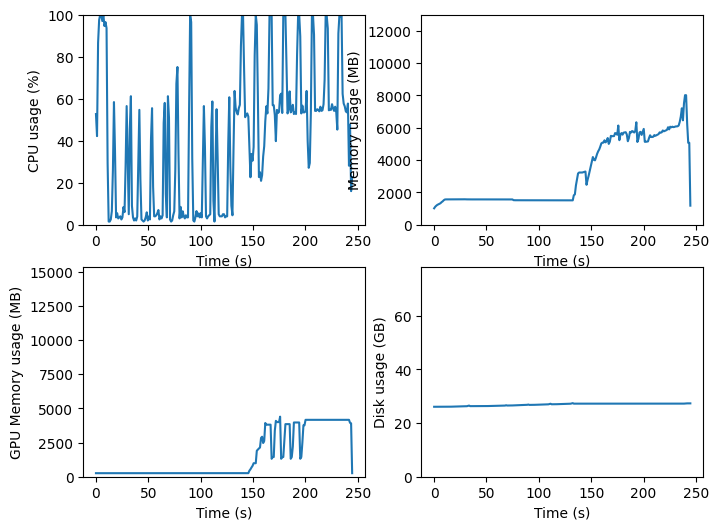

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704820134857660388518

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 11.57s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...
Predicting part 5 of 5 ...
  Predicted in 63.07s
Generating preview...
  Generated in 42.89s
Resampling...
Saving segmentations...
  Saved in 2.94s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.11s
Files moved successfully using the first command
Compressed 120073664 bytes into 4344384 bytes ==> 3.62%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704820134857660388518/1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704820134857660388518_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704820134857660388518/1.3.6.1.4.1.14519.5.2.1

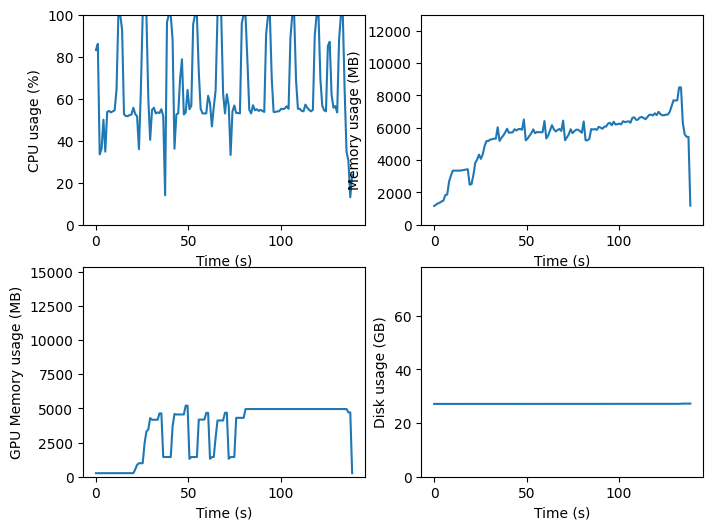

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428178414597614943330

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 11.20s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...
Predicting part 5 of 5 ...
  Predicted in 58.50s
Generating preview...
  Generated in 41.50s
Resampling...
Saving segmentations...
  Saved in 2.90s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Files moved successfully using the first command
Compressed 119025088 bytes into 4250462 bytes ==> 3.57%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428178414597614943330/1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428178414597614943330_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428178414597614943330/1.3.6.1.4.1.14519.5.2.1

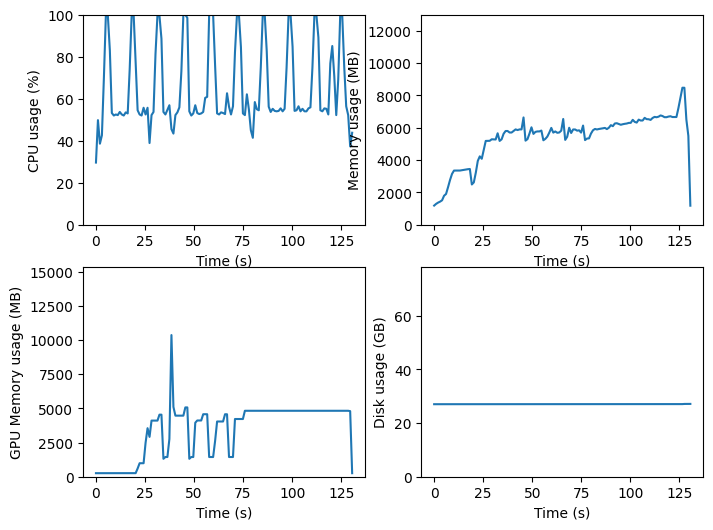

Processing series: 1.2.840.113654.2.55.304509822326866716583270698596704114762

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 3.81s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...
Predicting part 5 of 5 ...
  Predicted in 38.51s
Generating preview...
  Generated in 20.26s
Resampling...
Saving segmentations...
  Saved in 0.03s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Files moved successfully using the first command
Compressed 3157440 bytes into 194951 bytes ==> 6.17%
tar: Removing leading `/' from member names
/content/Inference/1.2.840.113654.2.55.304509822326866716583270698596704114762/1.2.840.113654.2.55.304509822326866716583270698596704114762_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.2.840.113654.2.55.304509822326866716583270698596704114762/1.2.840.113654.2.55.304509822326866716583270698

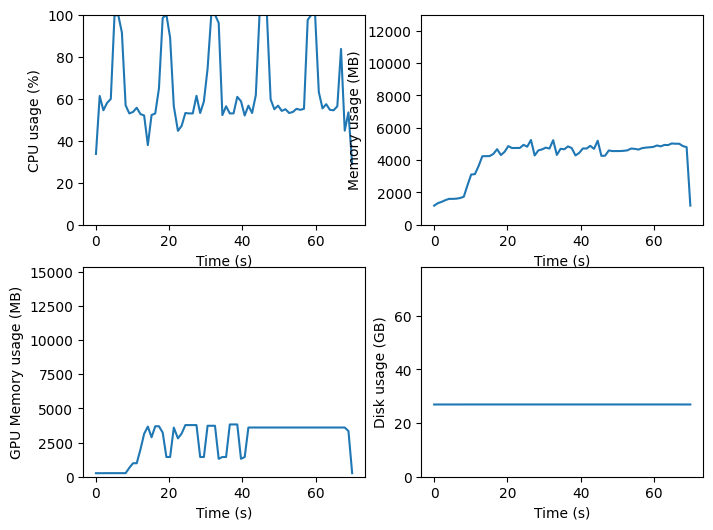

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 12.39s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...
Predicting part 5 of 5 ...
  Predicted in 58.54s
Generating preview...
  Generated in 41.71s
Resampling...
Saving segmentations...
  Saved in 2.17s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Files moved successfully using the first command
Compressed 136064448 bytes into 4340871 bytes ==> 3.19%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843/1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843/1.3.6.1.4.1.14519.5.2.1

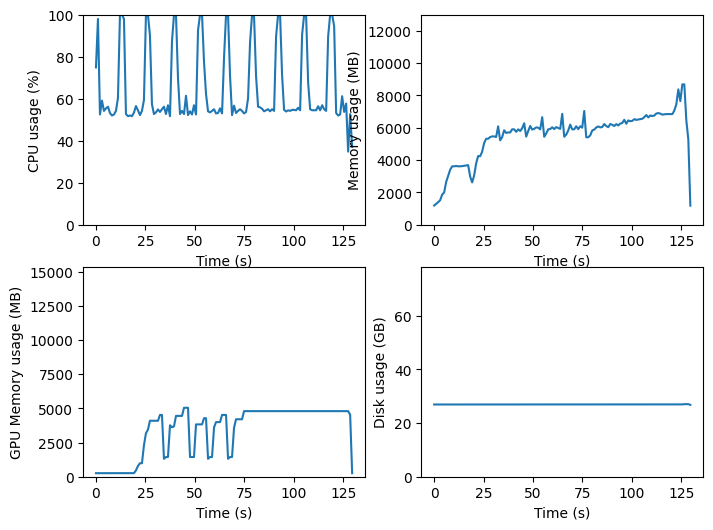

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 13.74s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...
Predicting part 5 of 5 ...
  Predicted in 81.26s
Generating preview...
  Generated in 58.25s
Resampling...
Saving segmentations...
  Saved in 2.28s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Files moved successfully using the first command
Compressed 117190080 bytes into 3244930 bytes ==> 2.77%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763/1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644803065327525536763/1.3.6.1.4.1.14519.5.2.1

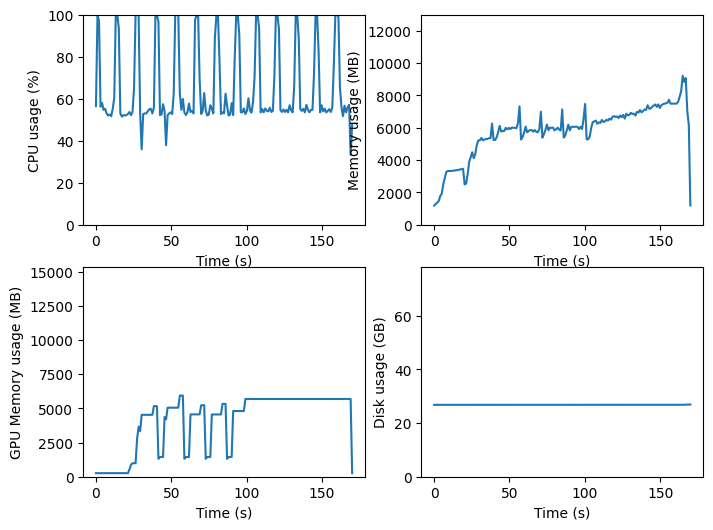

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111998259819454745216

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 10.11s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...
Predicting part 5 of 5 ...
  Predicted in 47.06s
Generating preview...
  Generated in 25.68s
Resampling...
Saving segmentations...
  Saved in 1.66s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Files moved successfully using the first command
Compressed 117714368 bytes into 3165273 bytes ==> 2.69%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111998259819454745216/1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111998259819454745216_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111998259819454745216/1.3.6.1.4.1.14519.5.2.1

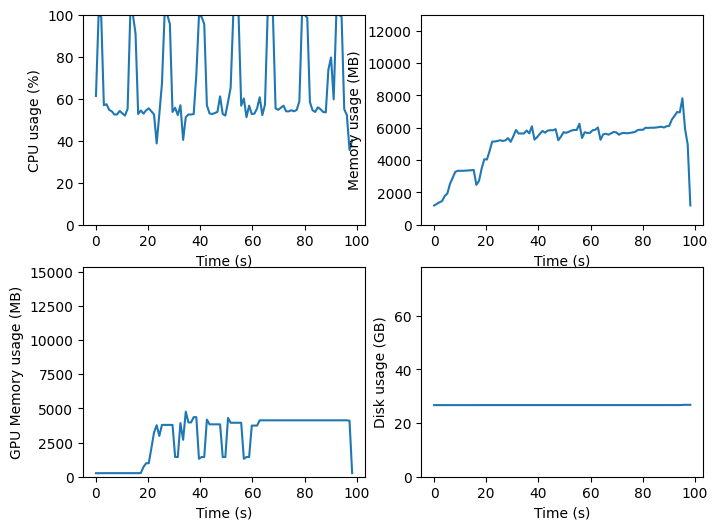

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747968640438384008250

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 9.64s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...
Predicting part 5 of 5 ...
  Predicted in 50.28s
Generating preview...
  Generated in 29.17s
Resampling...
Saving segmentations...
  Saved in 1.78s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Files moved successfully using the first command
Compressed 119287232 bytes into 3403579 bytes ==> 2.85%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747968640438384008250/1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747968640438384008250_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747968640438384008250/1.3.6.1.4.1.14519.5.2.1.

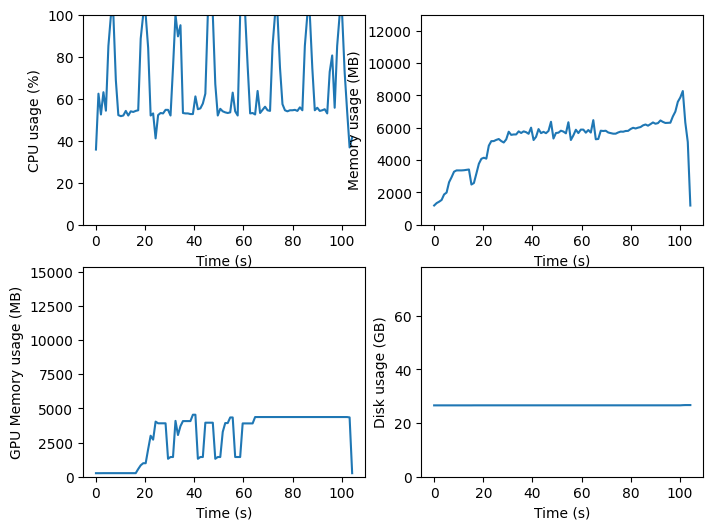

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643246158711092793890

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 9.93s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...
Predicting part 5 of 5 ...
  Predicted in 51.25s
Generating preview...
  Generated in 33.44s
Resampling...
Saving segmentations...
  Saved in 1.62s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.11s
Files moved successfully using the first command
Compressed 119811520 bytes into 4792444 bytes ==> 4.00%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643246158711092793890/1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643246158711092793890_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643246158711092793890/1.3.6.1.4.1.14519.5.2.1.

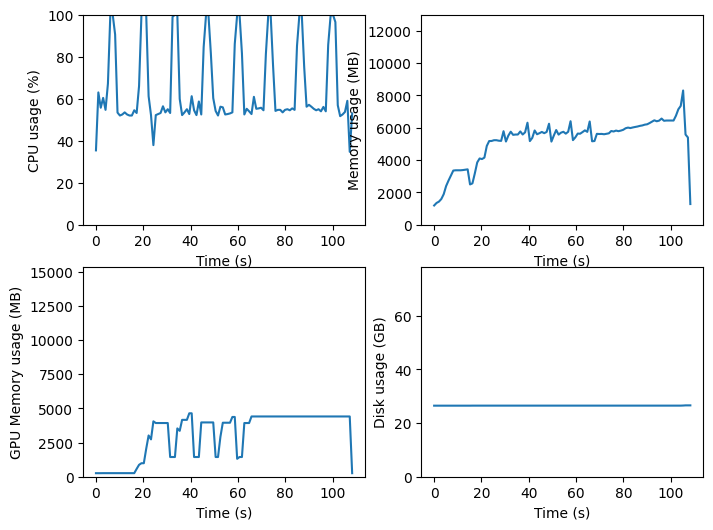

Processing series: 1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042535257813505318334

If you use this tool please cite: https://doi.org/10.48550/arXiv.2208.05868

Resampling...
  Resampled in 10.05s
Predicting part 1 of 5 ...
Predicting part 2 of 5 ...
Predicting part 3 of 5 ...
Predicting part 4 of 5 ...
Predicting part 5 of 5 ...
  Predicted in 45.30s
Generating preview...
  Generated in 28.74s
Resampling...
Saving segmentations...
  Saved in 1.54s
Calculating radiomics...
0it [00:00, ?it/s]
  calculated in 0.10s
Files moved successfully using the first command
Compressed 120073664 bytes into 3704578 bytes ==> 3.09%
tar: Removing leading `/' from member names
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042535257813505318334/1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042535257813505318334_statistics_radiomics.json
tar: Removing leading `/' from hard link targets
/content/Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042535257813505318334/1.3.6.1.4.1.14519.5.2.1

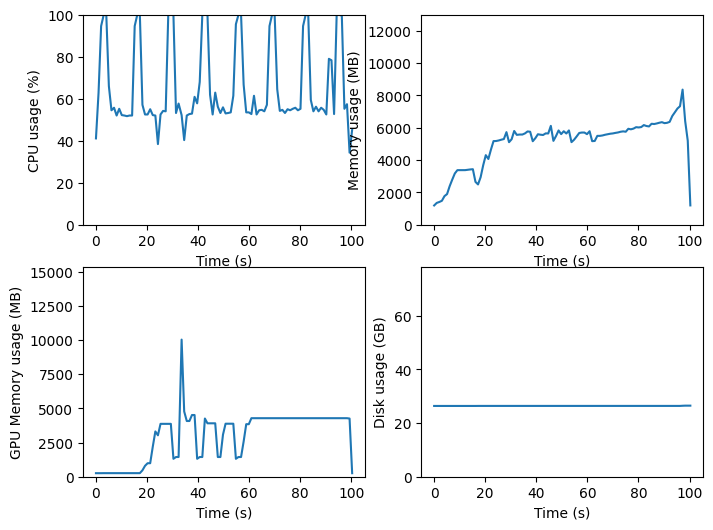

In [ ]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','total_segmentator_time',
                                      'archiving_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb', 
                                      'gpu_usage_mb', 'gpu_total_mb', 'gpu_type', 'disk_usage_all', 'disk_total'
                                      ])
if __name__ == "__main__":
    for series_id in os.listdir(f'{curr_dir}/{converterType}'):
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(inferenceTotalSegmentator, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb, gpu_usage_mb, gpu_total_mb, gpu_type, disk_usage_all, disk_total= mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]

                gpu_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_total_mb_idx, runtime_stats.columns.get_loc('gpu_total_mb')] = [[gpu_total_mb]]

                gpu_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[gpu_usage_mb_idx, runtime_stats.columns.get_loc('gpu_usage_mb')] = [[gpu_usage_mb]]

                disk_usage_gb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[disk_usage_gb_idx, runtime_stats.columns.get_loc('disk_usage_all')] = [[disk_usage_all]]

                runtime_stats['gpu_type']=gpu_type
                runtime_stats['disk_total']=disk_total    

                fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8, 6)) 

                ax1.plot(time_stamps, cpu_usage)
                ax1.set_ylim(0, 100)
                ax1.set_xlabel('Time (s)')
                ax1.set_ylabel('CPU usage (%)')

                ax2.plot(time_stamps, ram_usage_mb)
                ax2.set_ylim(0, ram_total_mb)
                ax2.set_xlabel('Time (s)')
                ax2.set_ylabel('Memory usage (MB)')

                ax3.plot(time_stamps, gpu_usage_mb)
                ax3.set_ylim(0, gpu_total_mb)
                ax3.set_xlabel('Time (s)')
                ax3.set_ylabel('GPU Memory usage (MB)')

                ax4.plot(time_stamps, disk_usage_all)
                ax4.set_ylim(0, disk_total)
                ax4.set_xlabel('Time (s)')
                ax4.set_ylabel('Disk usage (GB)')
                plt.show()

###Compressing Output Files

In [ ]:
start_time = time.time()
try:
  os.remove('inferenceNiftiFiles.tar.lz4')
  os.remove('metadata.tar.lz4')
except OSError:
  pass
!tar cvf - Inference | lz4 > inferenceNiftiFiles.tar.lz4
!tar cvf - metadata | lz4 > inferenceMetaData.tar.lz4
archiving_time = time.time() - start_time


Inference/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437/1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144105581727183705437.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704820134857660388518/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704820134857660388518/1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704820134857660388518.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428178414597614943330/
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428178414597614943330/1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428178414597614943330.nii.lz4
Inference/1.2.840.113654.2.55.304509822326866716583270698596704114762/
Inference/1.2.840.113654.2.55.304509822326866716583270698596704114762/1.2.840.113654.2.55.304509822326866716583270698596704114762.nii.lz4
Inference/1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465484755359888646843/
Inference/1.3.6.1.4.1.14519.5.2.

###**Utilization Metrics**

In [ ]:
runtime_stats.to_csv('runtime.csv')
runtime_stats['archiving_time']=archiving_time
try:
  os.remove('inferenceUsageMetrics.lz4')
except OSError:
  pass
!lz4 {curr_dir}/runtime.csv inferenceUsageMetrics.lz4
runtime_stats

Compressed 67170 bytes into 19784 bytes ==> 29.45%


,SeriesInstanceUID,total_segmentator_time,archiving_time,cpu_usage,ram_usage_mb,ram_total_mb,gpu_usage_mb,gpu_total_mb,gpu_type,disk_usage_all,disk_total
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.658966882144...,244.518092,0.337536,"[[[52.7, 42.2, 86.6, 97.5, 100.0, 100.0, 97.0,...","[[[1014.671875, 1110.1484375, 1174.58984375, 1...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 258.3125, 258...",[15360.0],b'Tesla T4',"[[[26.04474639892578, 26.04474639892578, 26.04...",78.189842
1,1.3.6.1.4.1.14519.5.2.1.7009.9004.129493269704...,138.155176,0.337536,"[[[83.2, 86.1, 33.5, 36.1, 50.0, 34.8, 53.7, 5...","[[[1161.4296875, 1241.671875, 1318.0859375, 13...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 258.3125, 261...",[15360.0],b'Tesla T4',"[[[27.10944366455078, 27.109451293945312, 27.1...",78.189842
2,1.3.6.1.4.1.14519.5.2.1.7009.9004.907225494428...,130.260347,0.337536,"[[[29.6, 49.8, 38.6, 42.6, 70.0, 100.0, 99.5, ...","[[[1183.078125, 1289.41015625, 1368.11328125, ...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 258.3125, 261...",[15360.0],b'Tesla T4',"[[[27.001079559326172, 27.001087188720703, 27....",78.189842
3,1.2.840.113654.2.55.30450982232686671658327069...,69.228002,0.337536,"[[[33.7, 61.3, 54.5, 58.0, 59.9, 99.5, 100.0, ...","[[[1180.7265625, 1332.72265625, 1412.95703125,...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[26.897090911865234, 26.897098541259766, 26....",78.189842
4,1.3.6.1.4.1.14519.5.2.1.7009.9004.204906251465...,128.805071,0.337536,"[[[74.9, 98.0, 52.5, 59.1, 54.2, 55.4, 56.2, 5...","[[[1185.0078125, 1285.33984375, 1394.2109375, ...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[26.893905639648438, 26.89391326904297, 26.8...",78.189842
5,1.3.6.1.4.1.14519.5.2.1.7009.9004.173131479644...,169.815923,0.337536,"[[[56.5, 100.0, 97.0, 56.2, 58.0, 54.7, 55.2, ...","[[[1184.71484375, 1278.921875, 1363.046875, 14...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[26.762969970703125, 26.762977600097656, 26....",78.189842
6,1.3.6.1.4.1.14519.5.2.1.7009.9004.533100474111...,97.866487,0.337536,"[[[61.3, 100.0, 99.0, 56.9, 57.4, 54.7, 54.0, ...","[[[1189.40625, 1285.4375, 1385.97265625, 1461....",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[26.662517547607422, 26.662525177001953, 26....",78.189842
7,1.3.6.1.4.1.14519.5.2.1.7009.9004.325615087747...,103.854771,0.337536,"[[[35.8, 62.4, 52.5, 63.1, 54.3, 85.1, 99.5, 1...","[[[1189.04296875, 1337.234375, 1423.3984375, 1...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[26.568462371826172, 26.568470001220703, 26....",78.189842
8,1.3.6.1.4.1.14519.5.2.1.7009.9004.329454839643...,108.308747,0.337536,"[[[35.4, 63.0, 55.7, 60.4, 54.7, 67.2, 100.0, ...","[[[1189.03515625, 1345.5234375, 1427.9765625, ...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[26.454814910888672, 26.454822540283203, 26....",78.189842
9,1.3.6.1.4.1.14519.5.2.1.7009.9004.114231323042...,99.982996,0.337536,"[[[41.1, 62.8, 94.6, 100.0, 100.0, 66.0, 54.5,...","[[[1190.4453125, 1348.2109375, 1406.04296875, ...",[12985.5390625],"[[[258.3125, 258.3125, 258.3125, 261.1875, 261...",[15360.0],b'Tesla T4',"[[[26.35126495361328, 26.351272583007812, 26.3...",78.189842
